# Kaggle : Titanic competition

## Introduction

This is the work I did for the famous Kaggle competition **Titanic**.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The notebook explains my work, the choices I did and the results I got.

In [1]:
# PANDAS and NUMPY for data processing
import pandas as pd
import math
import numpy as np
# SCIKIT LEARN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, cohen_kappa_score, accuracy_score, recall_score,precision_score
from sklearn.impute import SimpleImputer
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,StackingClassifier,BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
# KERAS
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
# MATPLOTLIB
import matplotlib.pyplot as plt

## Data processing 

First, I stored the data into pandas dataframes and applied some transformations on data.

In [2]:
# file paths
training_file = "../data/train.csv"
submission_file = "../data/test.csv"

RANDOM_STATE = 42

In [3]:
# creation of a dataframe for each file
training_df = pd.read_csv(training_file)
submission_df = pd.read_csv(submission_file)

I created 2 new features from the existing features **Age** and **Cabin**.
I created the feature **CabinProcess**, a categorical which only include the letter A, B, etc in the Cabin field and the feature **AgeProcess**, a categorical feature of 3 values (child, adult and senior) depending on the age.

In [4]:
def processCabin(cabin):
    """
    Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them
    """
    if cabin is not np.nan :
        return cabin[0]
    return cabin

training_df['CabinProcess']= training_df['Cabin'].apply(lambda x: processCabin(x))
submission_df['CabinProcess']= submission_df['Cabin'].apply(lambda x: processCabin(x))

In [5]:
def processAge(age):
    """
    Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them
    """
    if age is not np.nan :
        if age <= 18:
            return "child"
        elif age <= 40:
            return "adult"
        else :
            return "senior"
    return age

training_df['AgeProcess']= training_df['Age'].apply(lambda x: processAge(x))
submission_df['AgeProcess']= submission_df['Age'].apply(lambda x: processAge(x))

In [6]:
# training data overview 
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinProcess,AgeProcess
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,adult


In [8]:
# list of features uses for training
# categorical features
categorical_features = ["Sex","CabinProcess","Embarked","AgeProcess"]
# numerical features
numerical_features = ["Pclass","Age","SibSp","Parch","Fare"]
# all features
features = categorical_features + numerical_features
# output feature
output_feature = "Survived"

In [9]:
# training data overview
submission_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinProcess,AgeProcess
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,adult
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN,senior
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN,senior
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN,adult
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN,adult


### What is inside training data ?

I splited the data into a training set (80% of data) and a test set (20% of data). I trained the models on training set and tested models accuracies on test set. 

In [10]:
# split of dataframe into the test and training dataframe
training_df, test_df = train_test_split(training_df, test_size = 0.2)

In [11]:
print("Training set : ")
# number of rows per class
tr_nb = training_df['Survived'].value_counts()
print("Total row : ",tr_nb.sum(), " ---  Survivors : ", tr_nb[0] , " --- Death people", tr_nb[1])
print("Proportion of survivors : ", int(100*tr_nb[1]/tr_nb.sum()),'%')

print("\nTest set : ")
# number of rows per class
ts_nb = test_df['Survived'].value_counts()
print("Total row : ",ts_nb.sum(), " ---  Survivors : ", ts_nb[0] , " --- Death people", ts_nb[1])
print("Proportion of survivors : ", int(100*ts_nb[1]/ts_nb.sum()),'%')

Training set : 
Total row :  712  ---  Survivors :  436  --- Death people 276
Proportion of survivors :  38 %

Test set : 
Total row :  179  ---  Survivors :  113  --- Death people 66
Proportion of survivors :  36 %


The training dataset is **not perfectly balanced**, that is something we should take into account in the next part.

### Rebalancing training data something

The goal here is to achieve 50% of survival and 50% of dissapearence in the training set in order to not introduce bias into our models.  

In [12]:
REBALANCED = False
if REBALANCED :
    # Re - balancing training and test dataframe dataframe
    training_df = pd.concat([training_df.query("Survived == 0")[:tr_nb[1]], training_df.query("Survived == 1")], ignore_index=True)

    test_df = pd.concat([test_df, training_df.query("Survived == 0")[tr_nb[1]:]], ignore_index=True)
    ts_nb = test_df['Survived'].value_counts()
    test_df = pd.concat([test_df.query("Survived == 0")[:ts_nb[1]], test_df.query("Survived == 1")], ignore_index=True)

    # shuffle dataframe
    training_df = training_df.sample(frac = 1).reset_index(drop=True)
    test_df = test_df.sample(frac = 1).reset_index(drop=True)

In [13]:
if REBALANCED :
    print("Training set : ")
    # number of rows per class
    tr_nb = training_df['Survived'].value_counts()
    print("Total row : ",tr_nb.sum(), " ---  Survivors : ", tr_nb[0] , " --- Death people", tr_nb[1])
    print("Proportion of survivors : ", int(100*tr_nb[1]/tr_nb.sum()),'%')

    print("\nTest set : ")
    # number of rows per class
    ts_nb = test_df['Survived'].value_counts()
    print("Total row : ",ts_nb.sum(), " ---  Survivors : ", ts_nb[0] , " --- Death people", ts_nb[1])
    print("Proportion of survivors : ", int(100*ts_nb[1]/ts_nb.sum()),'%')

Now our training set is perfectly balanced with 50% of each attribute.

### Features Selection

Here we will check the importance of every features.

In [14]:
inputdt = np.array(training_df.dropna()[numerical_features].values, dtype='f')
outputdt = np.array(training_df.dropna()[output_feature].values, dtype='f').reshape(-1,1)
inputtestdt = np.array(test_df.dropna()[numerical_features].values, dtype='f')
outputtestdt = np.array(test_df.dropna()[output_feature].values, dtype='f').reshape(-1,1)

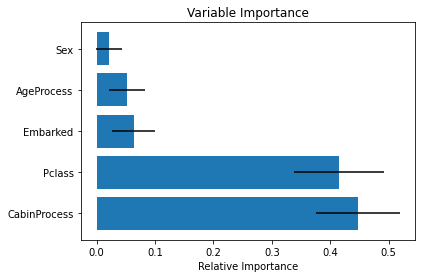

In [15]:
rdf_clf = RandomForestClassifier(n_estimators=100).fit(inputdt, outputdt)
importances=rdf_clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rdf_clf.estimators_],axis=0)

sorted_idx = np.argsort(importances)[::-1]

padding = np.arange(inputdt.size/len(inputdt)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, training_df.dropna()[features].columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

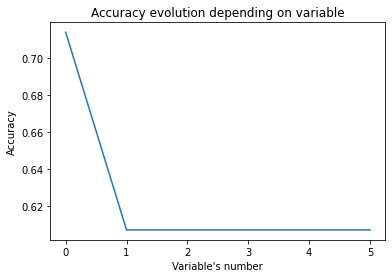

In [16]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(inputdt.shape[1]+1)
for f in np.arange(0, inputdt.shape[1]+1):
    X1_f = inputdt[:,sorted_idx[:f+1]]
    X2_f = inputtestdt[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,outputdt)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(outputtestdt,YKNN),3)
plt.plot(scores)
plt.xlabel("Variable's number")
plt.ylabel("Accuracy")
plt.title("Accuracy evolution depending on variable")
plt.show()

## Replacing missing values

We replace missing values in the data frame with sklearn Imputer modules.  
For categorical features, we replace the missing values with the most frequent one on non-missing values.
For numerical features, we replace the missing values with the mean of non-missing values. 

In [18]:
# separation of training dataframe into numerical and categorical set and output set.
training_num = np.array(training_df[numerical_features].values, dtype='f')
training_cat_df = training_df[categorical_features]
output_training_data = np.array(training_df[output_feature].values, dtype='f')

test_num = np.array(test_df[numerical_features].values, dtype='f')
test_cat_df = test_df[categorical_features]
output_test_data = np.array(test_df[output_feature].values, dtype='f')

submission_num = np.array(submission_df[numerical_features].values, dtype='f')
submission_cat_df = submission_df[categorical_features]

In [20]:
imp_cat = SimpleImputer(strategy='most_frequent')

# for training set categorial variables
training_cat = np.copy(training_cat_df).astype('str')
for col in range(len(categorical_features)):
    unique_val, val_idx = np.unique(training_cat[:,col],return_inverse=True)
    training_cat[:, col] = val_idx
training_cat = training_cat.astype('float')
training_cat[:, range(len(categorical_features))] = imp_cat.fit_transform(training_cat[:, range(len(categorical_features))])
# for test set categorial variables
test_cat = np.copy(test_cat_df).astype('str')
for col in range(len(categorical_features)):
    unique_val, val_idx = np.unique(test_cat[:, col],return_inverse=True)
    test_cat[:, col] = val_idx
test_cat = test_cat.astype('float')
test_cat[:, range(len(categorical_features))] = imp_cat.transform(test_cat[:, range(len(categorical_features))])
# for submission set categorial variables
submission_cat = np.copy(submission_cat_df).astype('str')
for col in range(len(categorical_features)):
    unique_val, val_idx = np.unique(submission_cat[:, col],return_inverse=True)
    submission_cat[:, col] = val_idx
submission_cat = submission_cat.astype('float')
submission_cat[:, range(len(categorical_features))] = imp_cat.transform(submission_cat[:, range(len(categorical_features))])


ohc = OneHotEncoder()
training_cat_bin = ohc.fit_transform(training_cat).toarray()
test_cat_bin = ohc.transform(test_cat).toarray()
submission_cat_bin = ohc.transform(submission_cat).toarray()


imp_num = SimpleImputer(strategy='mean')
# for training set numerical variables
training_num = imp_num.fit_transform(training_num)
# for test set numerical variables
test_num = imp_num.transform(test_num)
# for submission set numerical variables
submission_num = imp_num.transform(submission_num)

In [21]:
# normalisation of the training and test dataframes

# MIN MAX SCALER
# normalizer = MinMaxScaler()
# training_array = normalizer.fit_transform(training_num)
# test_array = normalizer.transform(test_num)

# STANDARD SCALER
normalizer = StandardScaler()
training_num_nrml = normalizer.fit_transform(training_num)
test_num_nrml = normalizer.transform(test_num)
submission_num_nrml = normalizer.transform(submission_num)

## PCA

I applied below a PCA (Principal Component Analysis) to normalize training data in order to find out the most relevant features. 
I take the 3 more relevant values and add them to the training data. 

In [22]:
# PCA on training data with 3 components
pca = PCA(n_components=3)
pca.fit(training_num_nrml)
print("Explained variance ratio : \n",pca.explained_variance_ratio_)
print("Total explained variance : \n",sum(pca.explained_variance_ratio_))
# projection of training, test and submission data into the new pca space
training_num_pca = pca.transform(training_num_nrml)
test_num_pca = pca.transform(test_num_nrml)
submission_num_pca = pca.transform(submission_num_nrml)

Explained variance ratio : 
 [0.33328325 0.32317    0.14805695]
Total explained variance : 
 0.8045102059841156


The PCA allows us to explain almost 80% of data variance.
The 3 new features got with the PCA are concatenate with the other features.

In [23]:
input_training_data = np.concatenate((training_num_nrml,training_num_pca,training_cat_bin),axis=1)

input_test_data = np.concatenate((test_num_nrml,test_num_pca,test_cat_bin),axis=1)

input_submission_data = np.concatenate((submission_num_nrml,submission_num_pca,submission_cat_bin),axis=1)

In [24]:
def plot_roc_curve(output_data, prediction,name=""):
    """
    This function takes the output data and the predicted output and plots the ROC curve
    """
    acc = roc_auc_score(output_data,prediction)
    fpr, tpr, threshold = roc_curve(output_data, prediction)
    plt.plot(fpr,tpr,label="data, auc="+str(acc))
    plt.title(name+' AUC-ROC curve')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [25]:
def performances(output_data, prediction,name="",verbose=1):
    """
    This function takes the output data and the predicted output and computes different metrics 
    """
    conf_mtx = confusion_matrix(output_data,prediction)
    roc_auc_sc = roc_auc_score(output_data,prediction)
    cohen_kappa_sc = cohen_kappa_score(output_data,prediction)
    accuracy_sc = accuracy_score(output_data,prediction)
    recall_sc = recall_score(output_data,prediction)
    precision_sc = precision_score(output_data,prediction)
    if verbose != 0:
        print("{0}  confusion_matrix : \n{1}".format(name,conf_mtx))
        print("{0} roc_auc_score : \n {1:.3f} ".format(name,roc_auc_sc))
        print("{0} cohen_kappa_score : \n {1:.3f} ".format(name,cohen_kappa_sc))
        print("{0} accuracy_score : \n {1:.3f} ".format(name,accuracy_sc))
        print("{0} recall_score : \n {1:.3f} ".format(name,recall_sc))
        print("{0} precision_score : \n {1:.3f} ".format(name,precision_sc))
    return conf_mtx, roc_auc_sc, cohen_kappa_sc, accuracy_sc, recall_sc, precision_sc

### Strategy

The goal here is to learn from the training dataset, if a given passenger would survived the titanic shipwreck.

To do so, we have a few information per passenger : 
- the passenger id (PassengerId)
- whether he survived or not (Survived)
- the ticket class (Pclass)
- his name (Name)
- his sex (Sex)
- his age (Age)
- the number of siblings/spouses aboard the Titanic (SibSp)
- the number of parents/children abroad the Titanic (Parch)
- the ticket number (Ticket)
- the passenger fare (Fare)
- the cabin number (Cabin)
- the port of embarkation (Embarked)

Those information include a number of interesting features (inputs) to predict the output : whether a passenger survive or not.

This is a **classification problem**, given a passenger, we would like to predict 1 if he survived and 0 otherwise. 

Different machine learning can be used in order predict that. 
For this particular one, I will try several approaches, **Sequential Neural Network**, **Logistic Regression**, **SVM**, **Tree classifiers** and compare the results.

## First approach : Sequential Neural Network

### Structure of the Neural Network :

- **the input layor** consists of the features given in the training dataset and explained above
- **two headen layers**
- **the output layer** consists in one neuron, activated by a **sigmoid** function. With a threshold of 0.5, this neuron gives the prediction of the death of a given passenger.

The NN is trained with **keras** and tested on the test dataset. 

### Neural network training

In [26]:
# definition of our keras model (using sequential neural network)
NN_model = Sequential()
# add a hidden layer with 64 nodes with activation relu
NN_model.add(Dense(64, input_dim=input_training_data.shape[1], activation='relu'))
# add a little dropout 
NN_model.add(Dropout(0.2))
# add an other hidden layer with 32 nodes with activation relu
NN_model.add(Dense(32, activation='relu'))
# add a little dropout
NN_model.add(Dropout(0.2))
# add an other hidden layer with 16 nodes with activation relu
NN_model.add(Dense(16, activation='relu'))
# add an other hidden layer with 8 nodes with activation relu
NN_model.add(Dense(8, activation='relu'))
# add the output layer with activation sigmoid
NN_model.add(Dense(1, activation='sigmoid'))



In [27]:
# compiling the model with binary_crossentropy loss, adam optimizer and accuracy metrics 
NN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# displaying the model
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

In [28]:
# training the model with training data
EPOCHS = 10
BATCH_SIZE = 8
# fiting model
history = NN_model.fit(input_training_data, output_training_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    shuffle=True,
    validation_data = (input_test_data, output_test_data))

Epoch 1/10
89/89 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5646 - val_loss: 0.6504 - val_accuracy: 0.7207
Epoch 2/10
89/89 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.7303 - val_loss: 0.6122 - val_accuracy: 0.7542
Epoch 3/10
89/89 [==============================] - 0s 2ms/step - loss: 0.6049 - accuracy: 0.7823 - val_loss: 0.5919 - val_accuracy: 0.7989
Epoch 4/10
89/89 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.7935 - val_loss: 0.5686 - val_accuracy: 0.7933
Epoch 5/10
89/89 [==============================] - 0s 2ms/step - loss: 0.5456 - accuracy: 0.8315 - val_loss: 0.5573 - val_accuracy: 0.7933
Epoch 6/10
89/89 [==============================] - 0s 2ms/step - loss: 0.5352 - accuracy: 0.8076 - val_loss: 0.5366 - val_accuracy: 0.8101
Epoch 7/10
89/89 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.8272 - val_loss: 0.5343 - val_accuracy: 0.7989
Epoch 8/10
89/89 [==

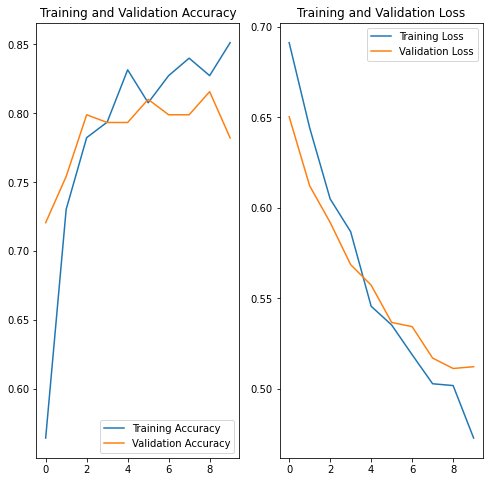

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# results of the predictions with trained neural network
NN_pred = [elt[0] for elt in np.round(NN_model.predict(input_test_data))]

confusion_matrix_nn, roc_auc_score_nn, cohen_kappa_score_nn, accuracy_score_nn, recall_score_nn, precision_score_nn = performances(output_test_data, NN_pred,name="NN")


NN  confusion_matrix : 
[[100  13]
 [ 26  40]]
NN roc_auc_score : 
 0.746 
NN cohen_kappa_score : 
 0.512 
NN accuracy_score : 
 0.782 
NN recall_score : 
 0.606 
NN precision_score : 
 0.755 


The neural netork has been trained with an **accuracy** of **80%**.

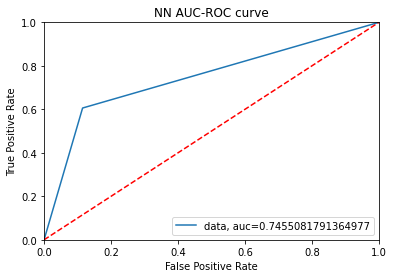

In [31]:
# calculate the false positive rate fpr and true positive tpr for all thresholds of the classification
plot_roc_curve(output_test_data, NN_pred,name="NN")

## Conclusion du RNN

The results I got are very satisfaying. The accuracy is very high and the network is able to learn from data and predict wheter a Titanic passenger will die or not.

In [34]:
# build the string for the kaggle submission
submission_content = "PassengerId,Survived\n"

pred_submission = [int(elt[0]) for elt in np.round(NN_model.predict(input_submission_data))]

for i in range(submission_df.shape[0]):
    submission_content += (str(submission_df["PassengerId"][i]) + "," + str(int(pred_submission[i])) + "\n")

#print(submission_content)


In [35]:
# second submission
with open("./submission2.csv","w") as sub_file:
    sub_file.write(submission_content)

## Classifiers

Below, I trained several classifiers on training set and tested the performances of the models on test set.

In [36]:
clfs = {
'SVR': svm.LinearSVC(random_state=RANDOM_STATE),
'SVM': svm.SVC(kernel="rbf",random_state=RANDOM_STATE),
'LOG': LogisticRegression(random_state=RANDOM_STATE,verbose=0,max_iter=150000, multi_class='ovr'),
'CART' : tree.DecisionTreeClassifier(random_state=RANDOM_STATE,criterion='gini'),
'ERF': ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2,random_state=RANDOM_STATE),
'SGD' :SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
'MLP' : MLPClassifier(random_state=RANDOM_STATE, max_iter=300),
'KNN': KNeighborsClassifier(n_neighbors=5),
'RF': RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE),
'BGC': BaggingClassifier(n_estimators=50),
'ADB': AdaBoostClassifier(n_estimators=50)
}

=============== SVR =============== 

Confusion matrix : 
[[93 20]
 [19 47]] 
ROC AUC Score : 0.768 
Cohen Kappa Score : 0.533 
Accuracy Score : 0.782 
Recall Score : 0.712 
Precision Score : 0.701 
Time : 0.041


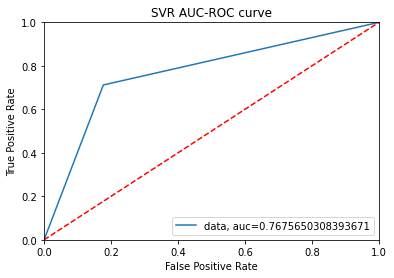



=============== SVM =============== 

Confusion matrix : 
[[93 20]
 [19 47]] 
ROC AUC Score : 0.768 
Cohen Kappa Score : 0.533 
Accuracy Score : 0.782 
Recall Score : 0.712 
Precision Score : 0.701 
Time : 0.028


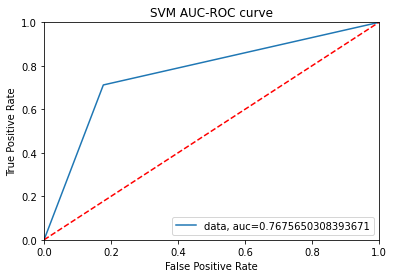



=============== LOG =============== 

Confusion matrix : 
[[93 20]
 [17 49]] 
ROC AUC Score : 0.783 
Cohen Kappa Score : 0.560 
Accuracy Score : 0.793 
Recall Score : 0.742 
Precision Score : 0.710 
Time : 0.088


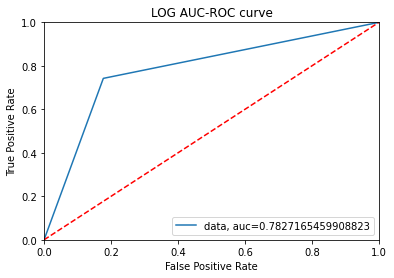



=============== CART =============== 

Confusion matrix : 
[[83 30]
 [23 43]] 
ROC AUC Score : 0.693 
Cohen Kappa Score : 0.378 
Accuracy Score : 0.704 
Recall Score : 0.652 
Precision Score : 0.589 
Time : 0.014


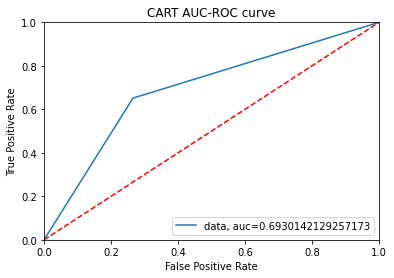



=============== ERF =============== 

Confusion matrix : 
[[80 33]
 [14 52]] 
ROC AUC Score : 0.748 
Cohen Kappa Score : 0.468 
Accuracy Score : 0.737 
Recall Score : 0.788 
Precision Score : 0.612 
Time : 0.036


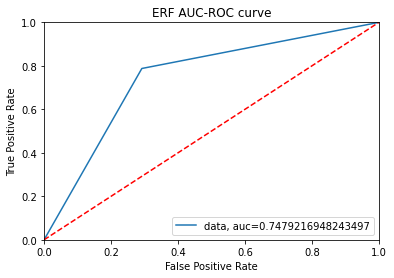



=============== SGD =============== 

Confusion matrix : 
[[97 16]
 [24 42]] 
ROC AUC Score : 0.747 
Cohen Kappa Score : 0.508 
Accuracy Score : 0.777 
Recall Score : 0.636 
Precision Score : 0.724 
Time : 0.012


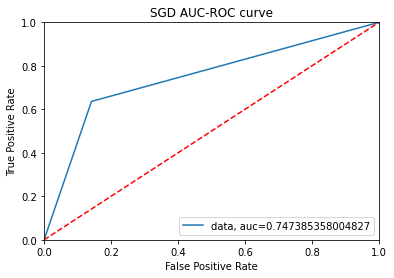



=============== MLP =============== 

Confusion matrix : 
[[97 16]
 [29 37]] 
ROC AUC Score : 0.710 
Cohen Kappa Score : 0.437 
Accuracy Score : 0.749 
Recall Score : 0.561 
Precision Score : 0.698 
Time : 2.270


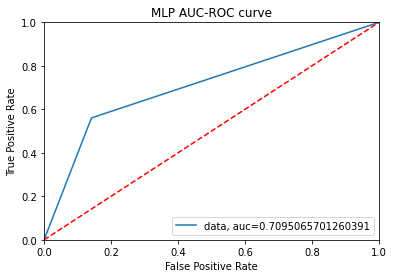



=============== KNN =============== 

Confusion matrix : 
[[99 14]
 [23 43]] 
ROC AUC Score : 0.764 
Cohen Kappa Score : 0.543 
Accuracy Score : 0.793 
Recall Score : 0.652 
Precision Score : 0.754 
Time : 0.024


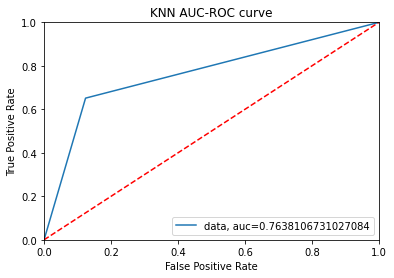



=============== RF =============== 

Confusion matrix : 
[[92 21]
 [16 50]] 
ROC AUC Score : 0.786 
Cohen Kappa Score : 0.563 
Accuracy Score : 0.793 
Recall Score : 0.758 
Precision Score : 0.704 
Time : 0.149


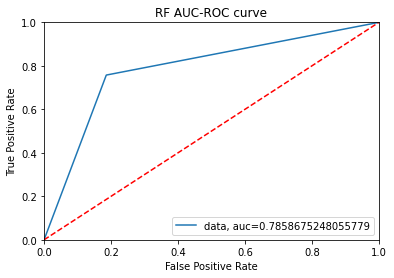



=============== BGC =============== 

Confusion matrix : 
[[92 21]
 [23 43]] 
ROC AUC Score : 0.733 
Cohen Kappa Score : 0.469 
Accuracy Score : 0.754 
Recall Score : 0.652 
Precision Score : 0.672 
Time : 0.249


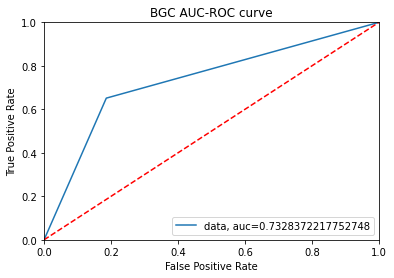



=============== ADB =============== 

Confusion matrix : 
[[89 24]
 [22 44]] 
ROC AUC Score : 0.727 
Cohen Kappa Score : 0.451 
Accuracy Score : 0.743 
Recall Score : 0.667 
Precision Score : 0.647 
Time : 0.146


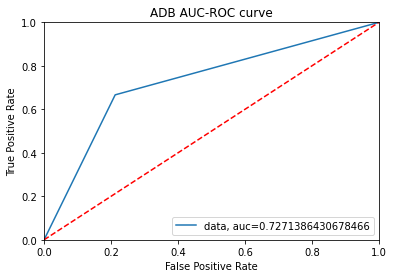

In [37]:
import time

for i in clfs :
    clf = clfs[i]
    t0 = time.time()
    clf.fit(input_training_data,output_training_data)
    prediction = clf.predict(input_test_data)
    confusion_matrix_clf, roc_auc_score_clf, cohen_kappa_score_clf, accuracy_score_clf, recall_score_clf, precision_score_clf = performances(output_test_data, prediction,name=i,verbose=0)
    print("=============== {0} =============== \n".format(i))
    print("Confusion matrix : \n{0} ".format(confusion_matrix_clf))
    print("ROC AUC Score : {0:.3f} ".format(roc_auc_score_clf))
    print("Cohen Kappa Score : {0:.3f} ".format(cohen_kappa_score_clf))
    print("Accuracy Score : {0:.3f} ".format(accuracy_score_clf))
    print("Recall Score : {0:.3f} ".format(recall_score_clf))
    print("Precision Score : {0:.3f} ".format(precision_score_clf))
    print("Time : {0:.3f}".format(time.time()-t0))
    plot_roc_curve(output_test_data, prediction,name=i)
    print()
    print()


## Conclusion 

The implemented methods, sequential neural network, logistic regression, SVM and tree classifiers (Cart and random forest), gave high accuracy, beetwen 78 and 85% for all technics. 

The approach above could be optimiserd or some other machine learning technics could be implemented in order to achieve a better score.

Stacking classifier accuracy :  0.7932960893854749
Stacking classifier confusion matrix : 
 [[98 15]
 [22 44]]


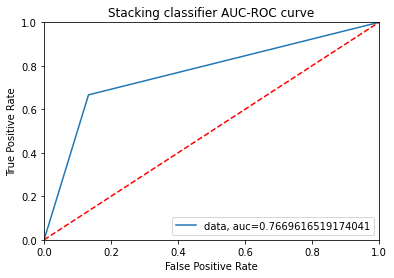

In [38]:
estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)),
     ('svr', make_pipeline(StandardScaler(),svm.LinearSVC(random_state=RANDOM_STATE))),
     ('id3',tree.DecisionTreeClassifier(criterion="entropy",random_state=RANDOM_STATE)),
     ('cart',tree.DecisionTreeClassifier(criterion="gini",random_state=RANDOM_STATE)),
     ('erf',ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2,random_state=RANDOM_STATE)),
     ('logr',LogisticRegression(random_state=RANDOM_STATE,verbose=0,max_iter=150000, multi_class='ovr')),
     ('svm',svm.SVC(kernel="rbf",random_state=RANDOM_STATE)),
     ('mlpc',MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(32,16, 8), random_state=RANDOM_STATE)),
     ('sgcd',SGDClassifier(loss="hinge", penalty="l2", max_iter=5)),
     ('bgc', BaggingClassifier(n_estimators=50)),
    ('adb', AdaBoostClassifier(n_estimators=50)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('nb', GaussianNB())
 ]
clf_stacking = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
 )

clf_stacking.fit(input_training_data, output_training_data)

stacking_acc = clf_stacking.score(input_test_data, output_test_data)


print("Stacking classifier accuracy : ",stacking_acc)

y_pred_sta=clf_stacking.predict(input_test_data)


sta_confusion_matrix = confusion_matrix(output_test_data,y_pred_sta)
print("Stacking classifier confusion matrix : \n",sta_confusion_matrix)


plot_roc_curve(output_test_data, y_pred_sta,name="Stacking classifier")